In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools 
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, get_interp_filename

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig2','interp_delay')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
n_tasks = str(len(rule_trains))
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '1'
lr = -7
ruleset = 'all'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/final/'+ruleset
m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [4]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/mod

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


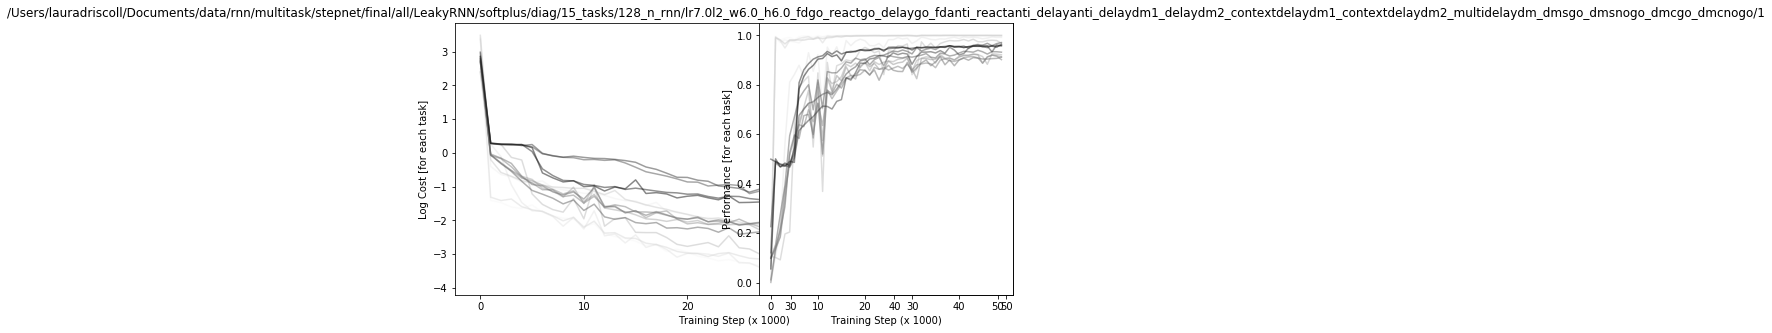

In [5]:
fig = plt.figure(figsize=(10, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')
task_list = hparams['rule_trains']

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    
    ax1 = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)

    ax2 = fig.add_subplot(1,2,2)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)

ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')    
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
plt.title(m)
plt.show()    

In [6]:
def remove_ax_lines(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
def label_categories(ax,rule):
    
    if 'dmc' in rule:
        plt.text(0.0, 0.05, 'Category 1', color='w', transform=ax.transAxes,fontsize = 12)
        plt.text(0.5, 0.05, 'Category 2', color='w', transform=ax.transAxes,fontsize = 12)
        
def Xcorr_trials(m,trial,x,epoch):
    
    t1 = trial.epochs[epoch][1]-5
    plt.imshow((np.corrcoef(x[:,trial_set,t1].T)))
    plt.title('time = '+str(t1))
    plt.ylabel('trial number')
    plt.xlabel('trial number')
#     label_categories(ax,rule)
    remove_ax_lines(ax)
    ax.set_yticks([])
    ax.set_xticks([])
    
def Xcorr_time(m,trial,x,trial_num = 0):
    
    plt.imshow((np.corrcoef(x[:,trial_num,:].T)))
    offset = 5
    al = .5

    for e in trial.epochs.keys():
        plt.plot([trial.epochs[e][0],trial.epochs[e][0]],[0,np.shape(x)[2]-1],'-w')
        plt.plot([0,np.shape(x)[2]-1],[trial.epochs[e][0],trial.epochs[e][0]],'-w')
        
        if e is not 'fix1':
            plt.text(trial.epochs[e][0]-2,-25,e[:-1]+ ' onset',rotation = 20,ha = 'left')

    plt.title('trial = '+str(trial_num),y = 1.2)
    plt.ylabel('time in trial')
    plt.xlabel('time in trial')
    remove_ax_lines(ax)

In [7]:
def plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 3, cat = False,labels=False):
    
    color_set = ['dimgray','gainsboro','dimgray','gainsboro']
    grad_cmap = plt.get_cmap('hsv')
    
    _,x1 = gen_X_from_model_dir(m,trial1)
    _,x2 = gen_X_from_model_dir(m,trial2)
    x12 = np.concatenate((x1,x2),axis = 1)
    
    n_trials_show = 20
    trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
    
#     ylim = np.max(ax.get_ylim())
#     xlim = np.max(ax.get_xlim())
    
    n_trials = len(trial1.stim_locs)
    stim_locs = np.concatenate((np.min(trial1.stim_locs,axis = 1),np.min(trial2.stim_locs,axis = 1)))
    task_binary = np.concatenate((np.ones(n_trials),np.zeros(n_trials)))
    response_binary = [((task_binary[x]==0) & (stim_locs[x]>np.pi)) or ((task_binary[x]==1) & (stim_locs[x]<np.pi))
                       for x in range(len(stim_locs))]
    
    for ti in range(len(trial_set)):
        
        trial_num = trial_set[ti]
        stim_color = grad_cmap(stim_locs[trial_num]/(2*np.pi))
        task_color = color_set[ti<int(len(trial_set)/2)]
        response_color = color_set[2+response_binary[trial_num]]
        
        if 'y' in which_axes:
            
            if cat==True:
                ax.plot(ti,-ms*.25,'s',color = response_color,markersize = ms)
            ax.plot(ti,-ms*.5,'s',color = stim_color,markersize = ms)
            ax.plot(ti,-ms*.75,'s',color = task_color,markersize = ms)
            
        if 'x' in which_axes:
            
            if cat==True:
                ax.plot(-ms*.25,ti,'s',color = response_color,markersize = ms)
            ax.plot(-ms*.5,ti,'s',color = stim_color,markersize = ms)
            ax.plot(-ms*.75,ti,'s',color = task_color,markersize = ms)
            
    if labels == True:

        if cat==True:
            plt.text(len(trial_set),-ms*.15,'respond to <$\pi$')
        plt.text(len(trial_set),-ms*.4,'stimulus angle')
        plt.text(len(trial_set),-ms*.65,'task')

In [8]:
rule_set_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'DecisionModality1', 'DecisionModality2', 'ContextModality1', 'ContextModality2', 'DecisionMultimodal',
              'Match2Sample', 'NonMatch2Sample', 'CategoryPro', 'CategoryAnti']

def interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov',tol_q = 1e-6,interp = True,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .001,
            n_skip_interps=2, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = [],fig_size = 4,
            alpha_max = 1.1,fontsize = 20,title_y = .9,tit_name = [],only_rel = False, stability_thresh = 1):
    
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': fontsize})
    n_interp = 20

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)
    if epoch_name1==epoch_name2:
        epoch_name = epoch_name1
        

    if interp:
        if script_name == 'interp_tasks_small_init_stim':
            trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
            trial2 = same_stim_trial(trial1, rule_set[1]) 
            trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        elif script_name == 'interp_tasks_small_init_mov':
            trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
            trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
            trial2 = same_mov_inds(trial1, trial2) 
            trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

        save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
        filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

        if only_rel:

            model = Model(m)
            with tf.Session() as sess:
                model.restore()
                model._sigma=0
                var_list = model.var_list
                params = [sess.run(var) for var in var_list]
                hparams = model.hp
                feed_dict = tools.gen_feed_dict(model, trial1, hparams)
                # run model
                h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

    
        for step_i in range(n_interp):#[9, 10, 8, 11, 7, 12, 6, 13, 5, 14, 4, 15, 3, 16, 2, 17, 1, 18, 19, 0]:
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            step_fps = fp_struct['xstar']
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            if only_rel:

                T_inds = get_T_inds(trial1,epoch_set[0])
                inputs_1 = trial1.x[T_inds,t_set[0],:]
                inputs_2 = trial2.x[T_inds,t_set[1],:]
                del_inputs = inputs_2 - inputs_1
                step_inputs = inputs_1+del_inputs*(step_i/n_interp)

                x_t = step_inputs
                h0 = h_tf[T_inds[0],t_set[0],:]

                h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
                rel_fp, _ = find_closest_fp_loc(h_t[-1,:],fp_struct['xstar'][fp_inds,:])
                fp_set = [rel_fp,]
            else:
                fp_set = range(len(fp_inds))

            for fp_ind in fp_set:

                fp = np.dot(sorted_fps[fp_ind,:],D_use)

                stability_metric = alpha_max - np.max(eig_decomps[fp_ind]['evals'].real)
                stability_metric = np.max((stability_metric,0))
                stability_metric = np.min((stability_metric,1))
                facecolors_3d = c
                facecolors_2d = c
                edgecolors = 'w'
                al = stability_metric
                
                if np.max(eig_decomps[fp_ind]['evals'].real)>stability_thresh:
                    if plot_unstable:
                        plt.plot(fp[0],fp[1],'o',c = c,linewidth = 10,markersize = 20,markerfacecolor = 'w',
                                 alpha = stability_metric)

                else:

                    plt.plot(fp[0],fp[1],'o',c = edgecolors,linewidth = 10,markersize = 20,markerfacecolor = facecolors_2d,
                                 alpha = stability_metric)

    for ri in range(2):

        rule = rule_str[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/8))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        T_inds_plot = range(np.max([T_inds[0]-1,0]),T_inds[-1])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

        ax = plt.subplot(111)
        stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
        y_locs = trial.y_loc[-1,:]

        if color_stim:
            plot_N( x_epoch[trial_set,:,:],D_use.T,stim1_locs[trial_set],
                   linewidth = fig_size+1,linestyle = '-', alpha = .5, markersize = 20)
        else:
            plot_N(x_epoch[trial_set,:,:],D_use.T,y_locs[trial_set],
                   linewidth = fig_size+1,linestyle = '-', alpha = .5, markersize = 20)
            
        plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = fig_size/2, 
               linestyle =  '-', alpha = .9, markersize = 10)

    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_xlim([x1-.2*abs(x1),x2+.2*abs(x2)])
    ax.set_ylim([y1-.2*abs(y1),y2+.2*abs(y2)])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()

    if len(tit_name)==0:
        if rule_set[0]==rule_set[1]:
            tit = 'Single Task : '+rule_name1+'\n '+r"$\bf{"+epoch_name1+"}$"+' vs. '+r"$\bf{"+epoch_name2+"}$"+' dynamics' 
            tit_name = rule_name1+'_'+epoch_name1+'_v_'+epoch_name2+'_dynamics_2d'
        else:       
            tit = r"$\bf{"+rule_name1+"}$"+' vs. \n'+r"$\bf{"+rule_name2+"}$"+ '\n '+epoch_name+' dynamics'
            tit_name = rule_name1+'_v_'+rule_name2+'_'+epoch_name+'_dynamics_2d'   
    else:
        tit = tit_name
        tit_name = rule_name1+'_v_'+rule_name2+'_'+epoch_name1+'_v_'+epoch_name2+'_dynamics_2d' 
    plt.title(tit,y = title_y)

    _, ax_rule_name, _, _ = take_names(epoch,rule_str[rule_axs])
    axes_label1 = r"$\bf{" + ax_rule_name + "}$"+' \n'+epoch_name+' PC1'
    axes_label2 = r"$\bf{" + ax_rule_name + "}$"+' \n'+epoch_name+' PC2'
    make_lil_axes(ax,[axes_label1,axes_label2],fontsize = fontsize)

    fig_fldr = 'interp_fps'
    if not os.path.exists(os.path.join(figpath,fig_fldr,script_name)):
        os.makedirs(os.path.join(figpath,fig_fldr,script_name))

    plt.savefig(os.path.join(figpath,fig_fldr,script_name,tit_name+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,script_name,tit_name+'.png'))
    plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


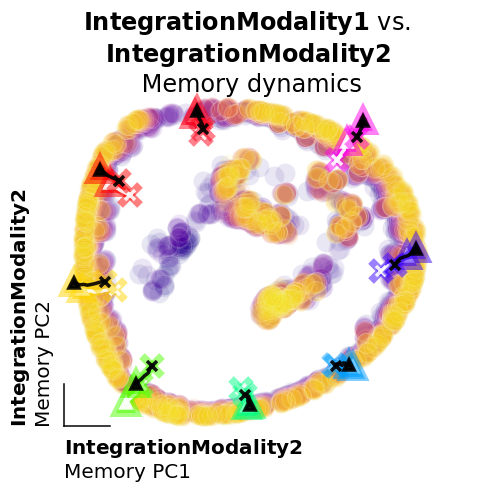

In [9]:
########## X TASK ###########
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/'

# from tools_lnd import interp2d, make_D_use
from tools_lnd import plot_N, make_lil_axes, comp_eig_decomp, same_mov_inds, take_names, make_D_use, gen_X_from_model_dir

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = [6,7]
epoch_set = ['delay2','delay2']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True

cmap_grad = plt.get_cmap('plasma')
script_name = 'interp_tasks_small_init_mov'

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = ['w','k'],
         interp = interp,q_thresh = .0000005,rule_axs = rule_axs, plot_unstable = True, n_skip_interps=1,
        figpath = figpath,fig_size = 7, color_stim = False, stability_thresh = 2)


In [10]:
########## X TASK ###########
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/'

# from tools_lnd import interp2d, make_D_use
from tools_lnd import plot_N, make_lil_axes, comp_eig_decomp, same_mov_inds, take_names, make_D_use, gen_X_from_model_dir

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = [6,7]
epoch_set = ['delay2','delay2']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['w','k']
script_name = 'interp_tasks_small_init_mov'


In [11]:
rule1 = rules_dict['all'][rule_set[0]]
rule2 = rules_dict['all'][rule_set[1]]
rule_str = [rule1,rule2]

if script_name == 'interp_tasks_small_init_stim':
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, rule_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
elif script_name == 'interp_tasks_small_init_mov':
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
    trial2 = same_mov_inds(trial1, trial2) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

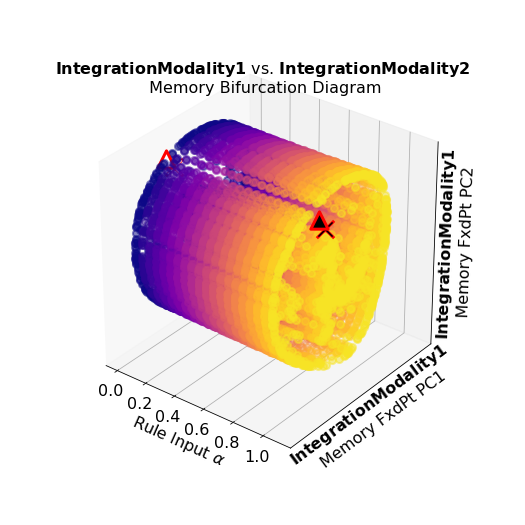

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

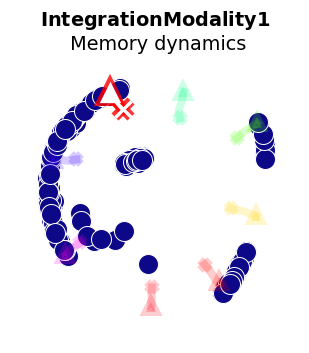

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


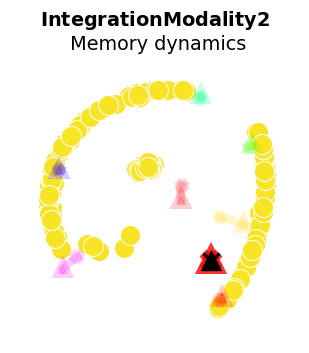

In [12]:
from tools_lnd import get_interp_filename, bifurc, plot_bifurc_ends

fig_size = 7
# q_thresh = 1e-6
q_thresh = .000005
rule_axs = 0
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)

fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                      filename_interp+'_step_'+str(0)+'.npz')

fp_struct = np.load(fp_dir)
sorted_fps = fp_struct['xstar']

pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(sorted_fps)
D_use = pca.components_.T
D_use[:,0] = -D_use[:,0]
ax_labels = 'pca_fp'

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
                       lims = [], view_ang = [31,-52],al_fp = .5)

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2, 
                 stability_thresh = 1.05,color_stim = False, figpath = figpath, ruleset = ruleset)

In [11]:
########## X TASK ###########

# from tools_lnd import interp2d, make_D_use
from tools_lnd import plot_N, make_lil_axes, comp_eig_decomp, same_mov_inds, take_names, make_D_use, gen_X_from_model_dir

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = [6,7]
epoch_set = ['delay2','delay2']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['gainsboro','dimgray']
script_name = 'interp_tasks_small_init_mov'

rule_axs = 0
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .0000006,rule_axs = rule_axs, plot_unstable = True, n_skip_interps=1,
        figpath = figpath,fig_size = 8, color_stim = False,stability_thresh = 2)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

TypeError: interp2d() got an unexpected keyword argument 'stability_thresh'

In [12]:
from tools_lnd import get_filename
trial_str = '_'.join(str(t) for t in trial_num)
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,ti)
f = os.path.join(m,'tf_fixed_pts_manytrials',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
_, ax_rule_name, _, _ = take_names(epoch,rule)

NameError: name 'rule' is not defined

In [16]:
rule_set_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'DecisionModality1', 'DecisionModality2', 'ContextModality1', 'ContextModality2', 'DecisionMultimodal',
              'Match2Sample', 'NonMatch2Sample', 'CategoryPro', 'CategoryAnti']

def interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov',tol_q = 1e-6,interp = True,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .001,
            n_skip_interps=2, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = [],fig_size = 4,
            alpha_max = 1.1,fontsize = 20,title_y = .9,tit_name = []):
    
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': fontsize})
    n_interp = 20

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)
    if epoch_name1==epoch_name2:
        epoch_name = epoch_name1
    
    for ri in range(2):

        rule = rule_str[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/8))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        T_inds_plot = range(np.max([T_inds[0]-1,0]),T_inds[-1])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

        ax = plt.subplot(111)
        stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
        y_locs = trial.y_loc[-1,:]

        if color_stim:
            plot_N( x_epoch[trial_set,:,:],D_use.T,stim1_locs[trial_set],
                   linewidth = fig_size+1,linestyle = '-', alpha = .5, markersize = 20)
        else:
            plot_N(x_epoch[trial_set,:,:],D_use.T,y_locs[trial_set],
                   linewidth = fig_size+1,linestyle = '-', alpha = .5, markersize = 20)
            
        plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = fig_size/2, 
               linestyle =  '-', alpha = .9, markersize = 10)
        
    if interp:
        if script_name == 'interp_tasks_small_init_stim':
            trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
            trial2 = same_stim_trial(trial1, rule_set[1]) 
            trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        elif script_name == 'interp_tasks_small_init_mov':
            trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
            trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
            trial2 = same_mov_inds(trial1, trial2) 
            trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

        save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
        filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

        for step_i in range(n_interp):#[9, 10, 8, 11, 7, 12, 6, 13, 5, 14, 4, 15, 3, 16, 2, 17, 1, 18, 19, 0]:
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            step_fps = fp_struct['xstar']
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                fp = np.dot(sorted_fps[fp_ind,:],D_use)

                stability_metric = alpha_max - np.max(eig_decomps[fp_ind]['evals'].real)
                facecolors_3d = c
                facecolors_2d = c
                edgecolors = 'w'
                al = stability_metric
                
                if np.max(eig_decomps[fp_ind]['evals'].real)>1:
                    if plot_unstable:
                        plt.plot(fp[0],fp[1],'o',c = c,linewidth = 10,markersize = 20,markerfacecolor = 'w',
                                 alpha = stability_metric)

                else:

                    plt.plot(fp[0],fp[1],'o',c = edgecolors,linewidth = 10,markersize = 20,markerfacecolor = facecolors_2d,
                                 alpha = stability_metric)


    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_xlim([x1-.2*abs(x1),x2+.2*abs(x2)])
    ax.set_ylim([y1-.2*abs(y1),y2+.2*abs(y2)])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()

    if len(tit_name)==0:
        if rule_set[0]==rule_set[1]:
            tit = 'Single Task : '+rule_name1+'\n '+r"$\bf{"+epoch_name1+"}$"+' vs. '+r"$\bf{"+epoch_name2+"}$"+' dynamics' 
            tit_name = rule_name1+'_'+epoch_name1+'_v_'+epoch_name2+'_dynamics_2d'
        else:       
            tit = r"$\bf{"+rule_name1+"}$"+' vs. \n '+r"$\bf{"+rule_name2+"}$"+ '\n '+epoch_name+' dynamics'
            tit_name = rule_name1+'_v_'+rule_name2+'_'+epoch_name+'_dynamics_2d'   
    else:
        tit = tit_name
        tit_name = rule_name1+'_v_'+rule_name2+'_'+epoch_name1+'_v_'+epoch_name2+'_dynamics_2d' 
    plt.title(tit,y = title_y)

    _, ax_rule_name, _, _ = take_names(epoch,rule_str[rule_axs])
    axes_label1 = r"$\bf{" + ax_rule_name + "}$"+' \n'+epoch_name+' PC1'
    axes_label2 = r"$\bf{" + ax_rule_name + "}$"+' \n'+epoch_name+' PC2'
    make_lil_axes(ax,[axes_label1,axes_label2],fontsize = fontsize)

    fig_fldr = 'interp_fps'
    if not os.path.exists(os.path.join(figpath,fig_fldr,script_name)):
        os.makedirs(os.path.join(figpath,fig_fldr,script_name))

    plt.savefig(os.path.join(figpath,fig_fldr,script_name,tit_name+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,script_name,tit_name+'.png'))
    plt.show()


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


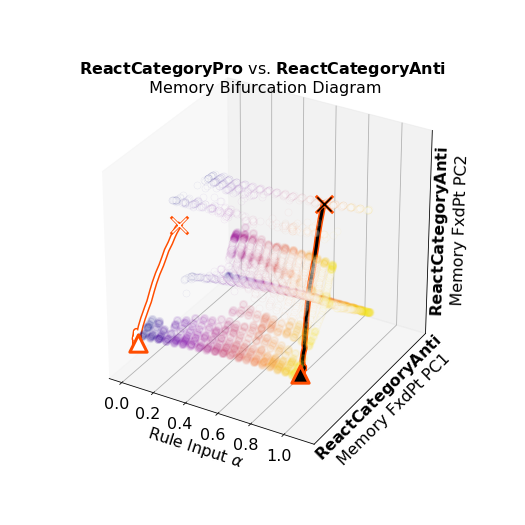

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

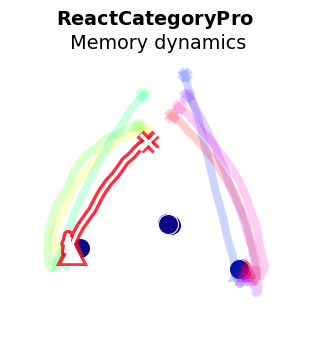

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


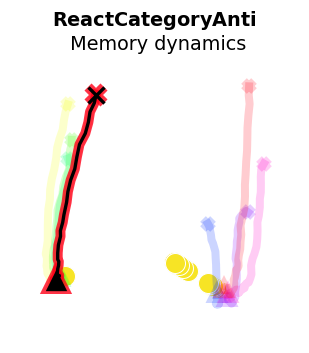

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

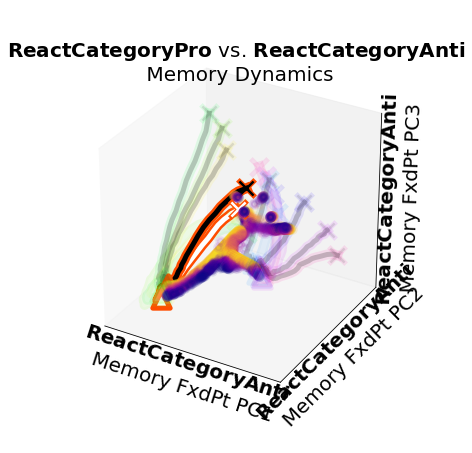

In [13]:
########## X TASK ###########

# from tools_lnd import interp2d
from tools_lnd import plot_N, make_lil_axes, comp_eig_decomp, same_mov_inds
from tools_lnd import take_names, make_D_use, gen_X_from_model_dir

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = [13,14]
epoch_set = ['delay1','delay1']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['w','k']
script_name = 'interp_tasks_small_init_mov'

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
                       lims = [], view_ang = [],al_fp = .1)

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2, 
                 stability_thresh = 1.05,color_stim = False, figpath = figpath, ruleset = ruleset)

bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,
           color_stim = False, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
           title_y = .9, n_trials = 8, stability_thresh = 2, threeD = True,
           lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = .1, 
           bifurc = False, plot_zero_plane = False)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

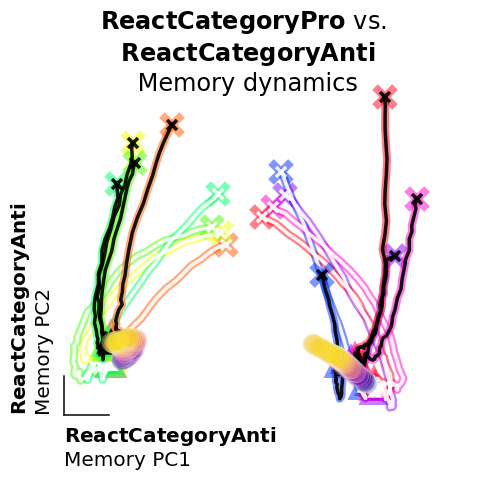

In [18]:
interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = 1e-6,rule_axs = rule_axs, plot_unstable = False, n_skip_interps=1,
         fig_size = 7, color_stim = False, figpath = figpath, cmap_discrete = ['w','k'], fp_first = True) 

In [19]:
%matplotlib notebook

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf

<IPython.core.display.Javascript object>


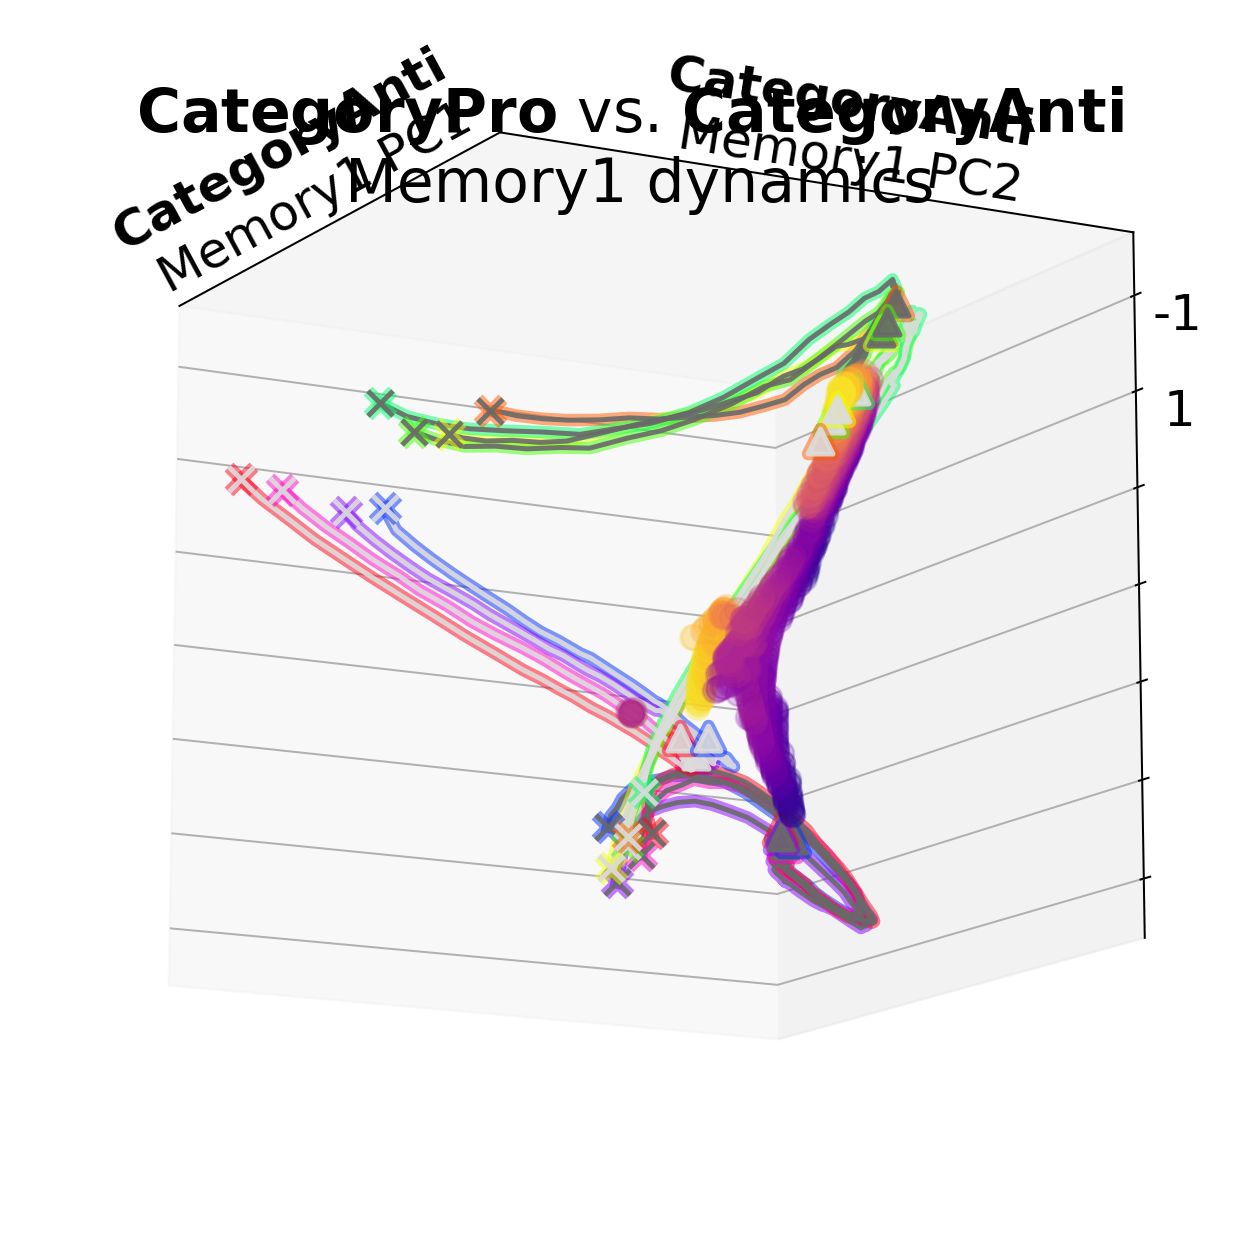

delay1
delay1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
0.158113883008419
Variables being 

In [12]:
########## X TASK ###########

from tools_lnd import interp2d, make_D_use, interp3d

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = [13,14]
epoch_set = ['delay1','delay1']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['gainsboro','dimgray']
script_name = 'interp_tasks_small_init_mov'

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = 1e-6,rule_axs = rule_axs, plot_unstable = False, n_skip_interps=1,
         fig_size = 7, color_stim = False, figpath = figpath, plot_zero_plane = False, lil_axes = False, ruleset = 'all') 
# ruleset = 'fig2_interp_delay',ax_labels = ['CategoryNogo PC1','CategoryNogo PC2','CategoryNogo PC3'],
#,plot_zero_plane = False

In [22]:
def plot_stim_angles(ax,stim_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False, show_rainbow = True):
        
    stim_cmap = plt.get_cmap('hsv')

    [x1,x2] = ax.get_xlim()
    x_diff = (x2-x1)/10
    [y1,y2] = ax.get_ylim()
    y_diff = (y2-y1)/10
    
    x_origin = x1+5*x_diff
    y_origin = y2+y_diff

    if show_rainbow:
        for theta in stim_locs:
            c = stim_cmap(theta/(2*np.pi))
            plt.plot([x_origin,x_origin+x_diff*np.cos(theta)],
                     [y_origin,y_origin+y_diff*np.sin(theta)],'-',c = c,alpha = .5,linewidth = 5)
        
        if show_stim:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.2,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Stimulus '+r'$\theta$',fontsize = 16,fontweight ='bold')
        else:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.4,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Response '+r'$\theta$',fontsize = 16,fontweight ='bold')
    
    
    if cat_task:
        plt.text(x_origin+x_diff*np.cos(0),y_origin-y_diff*np.sin(np.pi/2),'Category \n Boundary',fontsize = 14)
        plt.plot([x_origin-x_diff*np.cos(np.pi),x_origin+x_diff*np.cos(np.pi)],
                 [y_origin-y_diff*np.sin(np.pi),y_origin+y_diff*np.sin(np.pi)],':k',alpha = .9,linewidth = 3)
        
    if two_task:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = 'dimgray',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = 'dimgray',alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,'Task1',fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = 'dimgray',alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = 'gainsboro',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = 'gainsboro',alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = 'gainsboro',alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,'Task2',fontsize = 14,verticalalignment='center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])


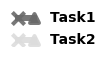

In [23]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(.4,.5),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
stim1_locs = np.min(trial.stim_locs[0:-1:10,[0,2]],axis=1) #only workds for single modality tasks
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = True, show_rainbow = False)

figname = 'task_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'task_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

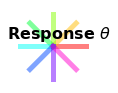

In [24]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = False)

figname = 'response_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'response_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

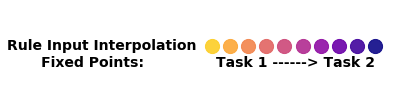

In [36]:
def interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
    cmap = plt.get_cmap('plasma')
    for step_i in range(0,n_interp,n_skip_interps):
        c = cmap(step_i/n_interp)
        ax.scatter(-step_i-3.5,0,s = 200,marker = 'o',edgecolors = c,facecolors = c,alpha = al)
    plt.text(-n_interp-1,-.06,'Task 1 ------> Task 2',fontsize = 14,fontweight ='bold')
    plt.text(-2*n_interp-4,-.06,'Rule Input Interpolation \n       Fixed Points:',fontsize = 14,fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])
#     [x1,x2] = ax.get_xlim()
#     [y1,y2] = ax.get_ylim()
#     ax.set_xlim([y1-3,y2])
    
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(2.6,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)

figname = 'interp_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'interp_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

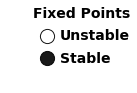

In [37]:
def fp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
    ax.scatter(0,1,s = 200,marker = 'o',edgecolors = 'k',facecolors = 'w',alpha = al)
    ax.scatter(0,0,s = 200,marker = 'o',edgecolors = 'k',facecolors = 'k',alpha = al)
    plt.text(0.04,1,'Unstable',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
    plt.text(0.04,0,'Stable',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
    plt.text(-0.04,2,'Fixed Points',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_ylim([y1-1,y2+1])
    
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
fp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)


figname = 'fp_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'fp.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()